In [45]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from IPython.display import display
import keras

In [21]:
def show(X):
    display(Image.fromarray(X))

In [2]:
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0, 0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

In [143]:
all_cervix_images = []

basepath = '/home/dataset/train/'
for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

basepath = '/home/dataset/Type_'
for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1][-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

In [144]:
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,/home/dataset/train/Type_1/0.jpg,jpg,Type_1
1,/home/dataset/train/Type_1/10.jpg,jpg,Type_1
2,/home/dataset/train/Type_1/1013.jpg,jpg,Type_1
3,/home/dataset/train/Type_1/1014.jpg,jpg,Type_1
4,/home/dataset/train/Type_1/1019.jpg,jpg,Type_1


In [145]:
all_cervix_images.shape

(8215, 3)

In [154]:
train

['/home/dataset/train/Type_3/477.jpg',
 '/home/dataset/train/Type_3/1153.jpg',
 '/home/dataset/train/Type_3/335.jpg',
 '/home/dataset/train/Type_3/324.jpg',
 '/home/dataset/train/Type_3/98.jpg',
 '/home/dataset/train/Type_3/170.jpg',
 '/home/dataset/train/Type_3/1350.jpg',
 '/home/dataset/train/Type_3/163.jpg',
 '/home/dataset/train/Type_3/344.jpg',
 '/home/dataset/train/Type_3/801.jpg',
 '/home/dataset/train/Type_3/812.jpg',
 '/home/dataset/train/Type_3/628.jpg',
 '/home/dataset/train/Type_3/1459.jpg',
 '/home/dataset/train/Type_3/258.jpg',
 '/home/dataset/train/Type_3/914.jpg',
 '/home/dataset/train/Type_3/69.jpg',
 '/home/dataset/train/Type_3/25.jpg',
 '/home/dataset/train/Type_3/309.jpg',
 '/home/dataset/train/Type_3/1470.jpg',
 '/home/dataset/train/Type_3/1166.jpg',
 '/home/dataset/train/Type_3/1157.jpg',
 '/home/dataset/train/Type_3/287.jpg',
 '/home/dataset/train/Type_3/220.jpg',
 '/home/dataset/train/Type_3/146.jpg',
 '/home/dataset/train/Type_3/1208.jpg',
 '/home/dataset/train

In [163]:
import glob
train1 = glob.glob('/home/dataset/train/**/*.jpg')
train1 =\
pd.DataFrame([[p.split('/')[4],p.split('/')[5],p] for p in train1], columns = ['type','image','path'])

train2 = glob.glob('/home/dataset/Type_*/*.jpg')
train2 =\
pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train2], columns = ['type','image','path'])

train = pd.concat([train1, train2]).reset_index(drop=True)

In [165]:
test = glob.glob('/home/dataset/test/*.jpg')
test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path'])

test_id = test.image.values
test.head()

,image,path
0,477.jpg,/home/dataset/test/477.jpg
1,178.jpg,/home/dataset/test/178.jpg
2,335.jpg,/home/dataset/test/335.jpg
3,324.jpg,/home/dataset/test/324.jpg
4,98.jpg,/home/dataset/test/98.jpg


In [166]:
train_ = im_stats(train)

Error path:/home/dataset/Type_1/5893.jpg
Error path:/home/dataset/Type_2/5892.jpg
Error path:/home/dataset/Type_2/2845.jpg


In [190]:
train_[train_['path'] == '/home/dataset/Type_1/5893.jpg']['size'].values[0]

'[ 0 ,   0 ]'

In [168]:
train_.shape

(8215, 4)

In [169]:
test_ = im_stats(test)

In [191]:
train_1 = train_[train_['size'] != '[ 0 ,   0 ]'].reset_index(drop=True) #remove bad images
test_1 = test_[test_['size'] != '[ 0 ,   0 ]'].reset_index(drop=True)    #remove bad images

In [194]:
train_1.shape,test_1.shape

((8212, 4), (512, 3))

In [17]:
def maxRect(img):
    # maxArea[0] : area, maxArea[1] : length of hist, maxArea[2] : last_position
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    #return (int(maxArea[3] + 1 - maxArea[0]/abs(maxArea[1] - maxArea[2])),\
    #        maxArea[2], maxArea[3], maxArea[1], maxArea[0])
    return (int(maxArea[3] + 1 - (maxArea[0]/abs(maxArea[1] - maxArea[2])/255.)),\
            maxArea[2], maxArea[3], maxArea[1], maxArea[0])

In [16]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = [] # 尋找  Rectangle 的高度
    position = []
    #print(len(hist))
    
    for i in range(len(hist)):
        
        #print(len(height), hist[i], height)
        
        if (len(height) == 0):
            if (hist[i] > 0):
                
                height.append(hist[i])
                position.append(i)
        else: 
            #print(i, height, hist[i] , position)
            #print(hist[i] > height[-1], hist[i] < height[-1])
            
            if (hist[i] > height[-1]):
                # 高度增加
                height.append(hist[i])
                position.append(i)
                
            elif (hist[i] < height[-1]):
                # 高度降低
                while (height[-1] > hist[i]):
                    
                    maxHeight = height.pop() # 把最後一個高度取出來
                    #print(maxHeight)
                    area = maxHeight * (i - position[-1]) # 計算面積
                    
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop() # 把前面高度上升時的位置記錄下來
                    
                    if (len(height) == 0): 
                        break
                        
                position.append(last_position)
                
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()   
                    
    while (len(height) > 0):
        
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
            
    return maxArea     

In [15]:
def cropCircle(img, resize):
    
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    #tile_size = (img.shape[0], img.shape[1])
    
    img = cv2.resize(img, dsize = tile_size)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    #http://monkeycoding.com/?p=615
    im2, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0] 
    ff = np.zeros((gray.shape[0], gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, (255, 255, 255), 3)
    
    # http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
    ff_mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 200)
    
    rect = maxRect(ff)
    rectangle = [min(rect[0], rect[2]), max(rect[0], rect[2]),\
                 min(rect[1], rect[3]), max(rect[1], rect[3])]
    img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)
    
    img_ = cv2.rectangle(img, (min(rect[1],rect[3]),
                             min(rect[0],rect[2])),
                        (max(rect[1],rect[3]),
                         max(rect[0],rect[2])), 255, 2)
    img_nocrop_r =  cv2.resize(img_, dsize = (resize, resize))
    img_crop_r =  cv2.resize(img_crop, dsize = (resize, resize))
    
    return img_crop_r, img_nocrop_r#, rectangle, tile_size]

In [11]:
def get_im_cv2(args):
    
    img = cv2.imread(args[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    crop_resized, nocrop_resized = cropCircle(img, args[1])
    
    return [args[0], crop_resized, nocrop_resized]

In [10]:
def image_features(paths, dim):
    
    imf_d1 = {}
    imf_d2 = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    #print(ret)
    
    for i in range(len(ret)):
        imf_d1[ret[i][0]] = ret[i][1]
        
    for i in range(len(ret)):
        imf_d2[ret[i][0]] = ret[i][2]
        
    ret = []
    fdata1 = [imf_d1[f] for f in paths]
    fdata1 = np.array(fdata1, dtype = np.uint8)
    
    fdata2 = [imf_d2[f] for f in paths]
    fdata2 = np.array(fdata2, dtype = np.uint8)
    
    return fdata1, fdata2

In [176]:
train_data1.shape

(1481, 64, 64, 3)

In [225]:
#%timeit np.save('ALL_TRAIN_SEG_32.npy', train_data1)

In [226]:
#%timeit np.save('ALL_TRAIN_NOSEG_32.npy', train_data2)

In [224]:
#data2 = np.load('ALL_TRAIN_SEG_32.npy')

In [215]:
train_data1.shape, train_data2.shape

((8212, 32, 32, 3), (8212, 32, 32, 3))

In [214]:
dim = 32

train_data1, train_data2 = image_features(train_1['path'], dim)

In [276]:
test_data1, test_data2 = image_features(test_1['path'], dim)

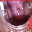

In [223]:
show(train_data1[200])

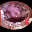

In [217]:
show(train_data2[200])

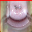

In [277]:
show(test_data1[200])

In [259]:
le = LabelEncoder()
train_target = le.fit_transform(train_1['type'].values)

In [260]:
train_Y = np.concatenate([train_target for i in range(1)])
train_X = np.concatenate([train_data1])

In [261]:
train_X.shape,train_Y.shape

((8212, 32, 32, 3), (8212,))

In [262]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split

batch_size = 32
num_classes = 3
epochs = 10
data_augmentation = True

In [263]:
x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_X, train_Y, test_size = 0.3, random_state = 17)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

x_train.shape,x_val_train.shape,y_train.shape, y_val_train.shape

((5748, 32, 32, 3), (2464, 32, 32, 3), (5748, 3), (2464, 3))

In [264]:
x_train.shape[1:]

(32, 32, 3)

In [265]:
model = Sequential()
model.add(Reshape((32, 32, 3), input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))

model.add(Conv2D(64, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [266]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_30 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
__________

In [278]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

x_test = test_data1.astype('float32')
x_test /= 255

In [271]:
model.fit(x_train, y_train, validation_data=(x_val_train, y_val_train), batch_size = 100, epochs = 200)

Train on 5748 samples, validate on 2464 samples
Epoch 1/200
5748/5748 [==============================] - 1s - loss: 1.0089 - acc: 0.5202 - val_loss: 0.9952 - val_acc: 0.5268

In [273]:
x_test

array([[[[ 1.        ,  0.        ,  0.        ],
         [ 1.        ,  0.        ,  0.        ],
         [ 1.        ,  0.        ,  0.        ],
         ..., 
         [ 1.        ,  0.        ,  0.        ],
         [ 1.        ,  0.        ,  0.        ],
         [ 1.        ,  0.        ,  0.        ]],

        [[ 1.        ,  0.        ,  0.        ],
         [ 0.57254905,  0.35294119,  0.41176471],
         [ 0.61960787,  0.40784314,  0.49411765],
         ..., 
         [ 0.48235294,  0.35294119,  0.35294119],
         [ 0.49803922,  0.36862746,  0.36078432],
         [ 0.63529414,  0.28235295,  0.27843139]],

        [[ 1.        ,  0.        ,  0.        ],
         [ 0.56470591,  0.35686275,  0.43921569],
         [ 0.59215689,  0.38039216,  0.47058824],
         ..., 
         [ 0.50588238,  0.37254903,  0.36862746],
         [ 0.51372552,  0.3764706 ,  0.36862746],
         [ 0.65490198,  0.29019609,  0.28235295]],

        ..., 
        [[ 1.        ,  0.        ,

In [275]:
x_test.shape

(512, 64, 64, 3)

In [279]:
pred = model.predict_proba(x_test)

 32/512 [>.............................] - ETA: 4s

In [280]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])

In [281]:
df['image_name'] = test_id

In [282]:
df = df[['image_name','Type_1','Type_2','Type_3']]

In [287]:
df.head()

,image_name,Type_1,Type_2,Type_3
0,477.jpg,3.386967e-01,0.607803,0.053500
1,178.jpg,2.293941e-02,0.001084,0.975977
2,335.jpg,2.529386e-07,0.714877,0.285123
3,324.jpg,4.209332e-01,0.576053,0.003014
4,98.jpg,2.178026e-05,0.999878,0.000100


In [290]:
df.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_seg_all_data.csv', index=False)

In [291]:
ls

ALL_TRAIN_NOSEG_32.npy  Resize.ipynb  rot_90.ipynb        submission2.csv
ALL_TRAIN_SEG_32.npy    array.npy     segmentation.ipynb  submission_rot90.csv
